# 计算物理B第五次作业

PB20511896 王金鑫

In [1]:
# !/usr/bin/env python
# -*- coding: utf-8 -*-

# ----------------------------------------------------------------
# @copyright (C), 2022, Bruce Wong, All rights reserved.
# @File Name   : main.ipynb
# @Author      : Bruce Wong
# @Version     : 
# @Date        : 2022-11-02 13:15:13
# @Description : 
# 
# The 5th homework of Computational Physics. Solving a Laplace 
# equation by finite element method.
# 
# ----------------------------------------------------------------


### 调用第三方库

- `matplotlib.pyplot`: 绘图。
- `time`: 调用当前时间以计算运行时间。

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import time

### 题目

$$
\left\{
\begin{matrix}
\nabla^2 \phi (x,y) = 0\\
\phi(x,0) = \phi(x,1) = 0\\
\phi(0,y) = \phi(1,y) = 1\\
0\leq x\leq1 ,\quad 0\leq y\leq 1
\end{matrix}
\right.
$$

- 使用有限元法求解方程，并使用超松弛迭代法求解最终线性方程组。其中自行优化松弛迭代参数与次数。

- 画出 $\phi (x,y)$ 的分布。

### 计算方法

原偏微分方程相当与一个满足第一类边界条件的正方形静电场

电荷密度 $\rho=0$ ，泛函为
$$
I(\phi) = \iint\limits_{D(L)} (\nabla \phi)^2 dxdy
$$

因此有限元法的最终线性方程组为 $(K)(\Phi)=0$ 将边界节点编号放在最后面可得
$$
\left\{
\begin{matrix}
(K_{11})(\Phi_1)=-(K_{12})(\Phi_2)\\
(\Phi_2)=(\Phi_0)
\end{matrix}
\right.
$$

将正方形场按如下方式划分为三角形。

| ![grids](grids.jpg) | ![grids2](grids2.jpg) |
|-|-|

共划分32x32个格子，2042个元素，31x31个内节点，128个节点在边界上。其中每个内节点会有6个相邻节点。元素编号和节点编号如左图所示。

$\Phi_{11}$（红色） 和 $\Phi_2$ （蓝色） 的编号如右图所示。

### 计算过程

In [3]:
Ngrids = 32
gridWidth = 1/Ngrids

n_0 = (Ngrids-1)*(Ngrids-1)
n_1 = (Ngrids+1)*(Ngrids+1)

Grids = [[0 for i in range(Ngrids+1)] for j in range(Ngrids+1)]
for i in range(Ngrids+1):
    Grids[0][i] = n_0+i
    Grids[Ngrids][i] = Ngrids*(Ngrids+1)+i
for i in range(Ngrids-1):
    Grids[i+1][0] = Grids[i][Ngrids]+1
    Grids[i+1][Ngrids] = Grids[i+1][0]+1
    for j in range(Ngrids-1):
        Grids[i+1][j+1] = i*(Ngrids-1)+j

# print(Grids)

x, y = [0 for i in range(n_1)], [0 for i in range(n_1)]
for i in range(Ngrids+1):
    for j in range(Ngrids+1):
        x[Grids[i][j]] = j*gridWidth
        y[Grids[i][j]] = (Ngrids-i)*gridWidth

K_1 = [[0 for i in range(n_1)] for j in range(n_0)]

Phi1 = [1 for i in range(n_0)]
Phi2 = [0]*(Ngrids+1) + [1]*2*(Ngrids-1) + [0]*(Ngrids+1)

定义元素类

In [4]:
class element(object):
    def __init__(self, i, j, m):
        # index of nodes
        self.ijm = [i, j, m]
        # self.i, self.j, self.m = i, j, m
        # some paraments
        self.a = [x[j]*y[m]-x[m]*y[j], x[m]*y[i]-x[i]*y[m], x[i]*y[j]-x[j]*y[i]] # i, j, m
        self.b = [y[j]-y[m], y[m]-y[i], y[i]-y[j]] # i, j, m
        self.c = [x[m]-x[j], x[i]-x[m], x[j]-x[i]] # i, j, m
        # area
        self.Delta = (self.b[0]*self.c[1]-self.b[1]*self.c[0])/2

    def K_ij(self, index1, index2):
        # Matrix K
        # Index: i-0 j-1 m-2
        # return K[i][j]
        return (self.b[index1]*self.b[index2]+self.c[index1]*self.c[index2])/(4*self.Delta)


按元素遍历，计算 $K_1$

先只算上三角，再由对称性算 $K_{11}$ 的下三角

In [5]:
# element loop
for i in range(Ngrids):
    for j in range(Ngrids):
        # element 1
        ele1 = element(i=Grids[i][j], j=Grids[i+1][j], m=Grids[i][j+1])
        # element 2
        ele2 = element(i=Grids[i+1][j], j=Grids[i+1][j+1], m=Grids[i][j+1])

        # index loop
        for index1 in range(3):
            for index2 in range(3):
                if (ele1.ijm[index1]<=ele1.ijm[index2] and ele1.ijm[index1]<n_0):
                    K_1[ele1.ijm[index1]][ele1.ijm[index2]] += ele1.K_ij(index1, index2)
                if (ele2.ijm[index1]<=ele2.ijm[index2] and ele2.ijm[index1]<n_0):
                    K_1[ele2.ijm[index1]][ele2.ijm[index2]] += ele2.K_ij(index1, index2)
        
for i in range(n_0):
    for j in range(0, i):
        K_1[i][j] = K_1[j][i]

计算 $K_{11}$ 和 $K_{12}$

In [6]:
K_11, K_12 = [[] for i in range(n_0)], [[] for i in range(n_0)]
for i in range(n_0):
    K_11[i] = K_1[i][:n_0]
    K_12[i] = K_1[i][n_0:]

求解方程组 $(K_{11})(\Phi_1)=-(K_{12})(\Phi_2)=(\Phi_3)$

利用Gauss-Seidel迭代法

$$
Ax=b \quad \Rightarrow \quad x = (I - D^{-1}A)x + D^{-1}b\\

\left\{
\begin{matrix}
A=I-D^{-1}A \\
b=D^{-1}b
\end{matrix}
\right. \quad => \quad x=Ax+b
$$ 

再取 $\omega=1$ 作超松弛迭代，实际上也就是Gauss-Seidel迭代，
取1是因为后验地发现 $\omega<1$ 的时候收敛速度较慢。

这里 $Phi3 = b \quad K_{11} = A \quad Phi1 = x$ 


In [7]:
# Calculate Phi3
Phi3 = [0]*n_0
for i in range(n_0):
    for j in range(n_1-n_0):
        Phi3[i] += -K_12[i][j]*Phi2[j]
    Phi3[i] /= K_11[i][i]
# Calculate K_11
for i in range(n_0):
    K_11_ii = K_11[i][i]
    for j in range(n_0):
        K_11[i][j] /= (-K_11_ii)
    K_11[i][i] = 0

w = 1
ZeroList = [0]*n_0
Phi1_new = Phi1[:]



定义迭代函数 `Iteration()`

In [8]:

def Iteration():
    Phi1 = Phi1_new[:]
    # Phi1_new = ZeroList[:]
    for i in range(n_0):
        Phi1_new[i] = Phi3[i]
        for j in range(n_0):
            Phi1_new[i] += K_11[i][j]*Phi1_new[j]
        Phi1_new[i] = w*Phi1_new[i] + (1-w)*Phi1[i]
    
    error = 0
    for i in range(n_0):
        error += (Phi1_new[i]-Phi1[i])**2
    return error


迭代

输出迭代耗时

这里用iters表示迭代次数上限

In [9]:
epsilon = 0.0001
IterTimes = 0

StartTime = time.process_time()
iters = range(1000)
print("Start iteration...")
for iter in iters:
    if epsilon > Iteration():
        break
    IterTimes += 1
print("Iteration Over.")
print(f"Iteration times: {IterTimes}\tProcess time: {time.process_time()-StartTime}")

Start iteration...
Iteration Over.
Iteration times: 262	Process time: 47.328125


In [10]:
phi_backup = Phi1_new[:]

绘制图像

In [11]:
Phi1_new += Phi2

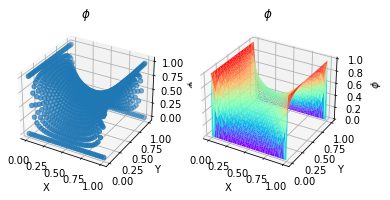

In [14]:
fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"})
# fig = plt.figure()
# aspect='equal'
# ax1 = fig.add_subplot(111, projection="3d")
ax1, ax2 = ax[0], ax[1]

ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("$\phi$")
ax1.set_title('$\phi$')
ax1.scatter3D(x, y, Phi1_new)

# ax2 = fig.add_subplot(111, projection="3d")
ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("$\phi$")
ax2.set_title('$\phi$')
ax2.plot_trisurf(x, y, Phi1_new, cmap='rainbow')

plt.show()